In [35]:
%load_ext autoreload
%autoreload 2
from load import *
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
import load
import torch
from liftpose.vision_3d import XY_coord, Z_coord

reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

# decleare data parameters
par_train = {'data_dir' : '/data/LiftPose3D/mouse_prism', # change the path 
       'out_dir'        : './out',
       'train_subjects' : ['G6AE1','G6AE2','G6AE3','G6AE5'],
       'test_subjects'  : ['G6AE6'],
       'actions'        : ['control']}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# Load data
train, train_keypts, _ = load.load_3D(par['data_dir'], subjects=par['train_subjects'], actions=par['actions'])
test,  test_keypts, _ = load.load_3D(par['data_dir'], subjects=par['test_subjects'],  actions=par['actions'])
# project data
train_2d, train_3d = XY_coord(train), Z_coord(train)
test_2d, test_3d  = XY_coord(test), Z_coord(test)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
from liftpose.main import train as lp3d_train
lp3d_train(train_2d=train_2d, test_2d=test_2d, train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts, test_keypts=test_keypts, 
           **{k:par[k] for k in ['roots', 'target_sets', 'out_dir']})

[main.py:89]:INFO:Saving pre-processed 2D data at /home/user/Desktop/LiftPose3D/examples/mouse_prism/out/stat_2d.pth.tar.
[main.py:111]:INFO:Saving pre-processed 3D data at /home/user/Desktop/LiftPose3D/examples/mouse_prism/out/stat_3d.pth.tar.
[main.py:138]:INFO:Starting training model
[main.py:147]:DEBUG:
==================Options=================
[main.py:148]:DEBUG:{   'batch_size': 64,
    'data_dir': '/home/user/Desktop/LiftPose3D/examples/mouse_prism/out',
    'dropout': 0.5,
    'epochs': 10,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 100000,
    'lr_gamma': 0.96,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/home/user/Desktop/LiftPose3D/examples/mouse_prism/out',
    'out_dir': '/home/user/Desktop/LiftPose3D/examples/mouse_prism/out',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:149]:DEBUG:===========================

Epoch 0 | Loss Test 0 | Loss Train 2.2633|: 100%|██████████| 523/523 [00:06<00:00, 75.42it/s]
Epoch 1 | Loss Test 1.6184 | Loss Train 1.0085|: 100%|██████████| 523/523 [00:06<00:00, 78.85it/s] 
Epoch 2 | Loss Test 1.4393 | Loss Train 0.88179|: 100%|██████████| 523/523 [00:06<00:00, 78.54it/s]
Epoch 3 | Loss Test 1.3212 | Loss Train 0.84478|: 100%|██████████| 523/523 [00:06<00:00, 79.57it/s] 
Epoch 4 | Loss Test 1.5818 | Loss Train 0.82613|: 100%|██████████| 523/523 [00:06<00:00, 79.01it/s]
Epoch 5 | Loss Test 1.8452 | Loss Train 0.80918|: 100%|██████████| 523/523 [00:05<00:00, 89.56it/s] 
Epoch 6 | Loss Test 1.0736 | Loss Train 0.78383|: 100%|██████████| 523/523 [00:07<00:00, 73.87it/s]
Epoch 7 | Loss Test 1.0537 | Loss Train 0.76719|: 100%|██████████| 523/523 [00:06<00:00, 76.49it/s]
Epoch 8 | Loss Test 1.3134 | Loss Train 0.74674|: 100%|██████████| 523/523 [00:06<00:00, 75.71it/s]
Epoch 9 | Loss Test 1.2986 | Loss Train 0.73829|: 100%|██████████| 523/523 [00:05<00:00, 95.12it/s] 


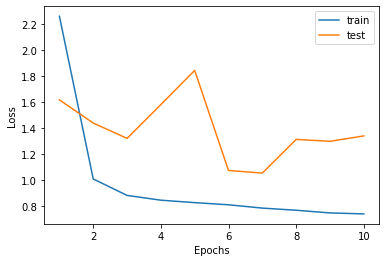

In [32]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

In [41]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:154]:INFO:starting testing in path: ./out
[lift.py:54]:INFO:total params: 4.23M
[lift.py:60]:INFO:loading ckpt from './out/ckpt_best.pth.tar'
[lift.py:68]:INFO:ckpt loaded (epoch: 10 | err: 2.1748151779174805)


/home/user/anaconda3/envs/lf3d/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (6) must match the size of tensor b (64) at non-singleton dimension 1

In [39]:
from liftpose.postprocess import load_test_results
data = torch.load(par['out_dir'] + "/test_results.pth.tar")
stat_2d, stat_3d = (
    torch.load(par['out_dir'] + "/stat_2d.pth.tar"),
    torch.load(par['out_dir'] + "/stat_3d.pth.tar"),
)
test_3d_gt, test_3d_pred = load_test_results(data, stat_2d, stat_3d)

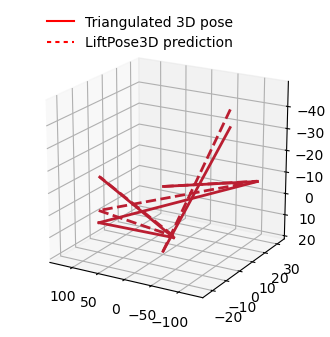

In [40]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=200, azim=60)

t = 900
plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"])